# Detección de carriles en video usando transformada de Hough

### Navegación Autónoma (Gpo10) MR4010.10
- Profesor titular: Dr. David Antonio Torres
- Profesor asistente: Maricarmen Vázquez Rojí

### Integrantes del Equipo 16
- A01793469 - Alberto Patraca Sotomayor
- A01794818 – Juan Ricardo Albarracin Barbosa
- A00354910 - Fabian Munoz Aguirre
- A01066428 - Erick de Jesus Hernández Cerecedo
        

## Table of Contents
1. [Importación de librerias](#libraries)
2. [Definición de ubicación de archivos](#path)
3. [Función región de interés](#interes)
4. [Función escala de grises](#grises)
5. [Función extracción de lineas](#lineas)
6. [Selección de videos](#videos)
7. [Explicación de funcionamiento](#explicacion)
8. [Visualización del funcionamiento del código](#funcionamiento)
9. [Conclusiones](#conclusion)

### Librerias <a class="anchor" id="libraries" ></a>
Importamos las librerías que vamos a requerir.

In [1]:
# cv2 (OpenCV) nos ayuda al procesamiento de imágenes y videos (conjuntos de imágenes).
import cv2

# numpy es bastante útil para el manejo de matrices
import numpy as np

# matplotlib ayuda mostrando imágenes en el notebook.
import matplotlib.pyplot as plt

# copy ayuda al manejo de elementos mutables
import copy as cp

### Definición de ubicación de archivos <a class="anchor" id="path" ></a>
Definimos nuestra ubicación local de trabajo, se requiere que el video original se encuentre dentro de esta dirección para poder leerlo y posteriormente guardar el modificado. Esta celda es la única que debería editarse según se requiera debido a la ubicación del video.

In [8]:
work_dir = 'C:/Users/erick/Downloads'

### Función región de interés <a class="anchor" id="interes" ></a>
Definimos una función para poder seleccionar nuestra región de interés 

In [9]:
def extract_region(image, region):
    #Definimos una matriz de ceros del mismo tamaño que la imagen recibida
    mask = np.zeros_like(image)
    
    """
    El atributo "shape" de la imagen contiene los siguientes datos:
    1. En primera posición, la cantidad de pixeles en el eje "x" (horizontal)
    2. En segunda posición, la cantidad de pixeles en el eje "y" (vertical)
    3. (Opcional) En la 3ra posición, si es que lo tiene, la cantidad de canales de color que posee la imagen
    """
    #Checamos la existencia de la tercera posición del atributo "shape", para definir la cantidad de canales de color
    
    if len(image.shape) > 2:
        # Si existe la 3ra posición, extraemos de ahí la cantidad de canales
        colors_count = image.shape[2]
    else:
        # Si no existe una 3ra posición (escala de grises), definimos la cantidad de canales como 1
        colors_count = 1
    
    # Definimos un tuple que tiene tantas posiciones como cantidad de canales de color, asignando el valor 255 
    # en cada una referente al color blanco
    white_tuple = (255,) * colors_count
    
    """ 
    Tomamos la matriz de ceros "mask" que habíamos definido, y en la región establecida por 
    las esquinas de la variable "region" (parejas de coordenadas "x" y "y"), 
    asignamos valores de color blanco "white tuple"
    """
    cv2.fillPoly(mask, region, white_tuple)
    
    """
    "Eliminamos" los pixeles fuera de la región de interés aplicando un "and" lógico, bit por bit
    entre la imagen original "image" y la matriz "mask", donde "mask" sea 0, 
    se eliminan los pixeles correspondientes de "image".
    """
    interest_image = cv2.bitwise_and(image, mask)
    
    # Regresamos el valor de la imagen modificada y la máscara utilizada
    return interest_image, mask

### Función escala de grises <a class="anchor" id="grises" ></a>
Definimos la función que nos ayudará a convertir la imagen original a escala de grises, y posteriormente extraer los bordes de la imagen

In [64]:
def gray_and_crop_edges(img):
    
    # Obtenemos la altura y anchura, en pixeles, de la imagen original
    height = img.shape[0]
    width = img.shape[1]
    
    """
    Definimos los vértices de nuestra región de interés, relativo a las medidas de la imagen
    Inicialmente los establecemos en una lista, para posteriormente convertirlos a un arreglo de numpy, 
    con tipo de dato "int32"
    """
    interest_area_li = [(0, height),
                    (0, 8*height/10), 
                    (4*width/10, 2*height/3.5),
                    (5*width/10, 2*height/3.5),
                    (7*width/6, height)]

    interest_area_ar = np.array([interest_area_li], np.int32)
    
    # Convertimos la original en escala de grises    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Extraemos los bordes de la imagen en escala de grises mediante el algoritmo de detección de bordes "Canny"
    edges = cv2.Canny(gray, 50, 150)
    
    """
    Ya teniendo la imagen de los bordes, aplicamos la función "extract_region" previamente definida,
    para extraer solamente la región de interés
    """
    cropped_edges, _ = extract_region(edges, interest_area_ar)
    
    """
    Aplicamos lo mismo con la imagen original, donde obtenemos la imagen recortada solo en la región de interés, 
    al igual que la máscara utilizada
    """
    masked_image, interest_mask = extract_region(img, interest_area_ar)
    
    # Regresamos la imagen de la región de interés de los bordes extraidos, la máscara y su aplicación a la imagen original
    return cropped_edges, interest_mask, masked_image

### Función extracción de lineas <a class="anchor" id="lineas" ></a>
Definimos una función para extraer líneas a partir de los bordes y juntarlas todas para poder mostrarlas en la imagen.

In [11]:
def extract_and_merge_lines(image):
    """
    Mandamos la imagen original a la función "gray_and_crop_edges" previamente definida, la cual nos regresa 
    los bordes dentro de nuestra región de interés
    """
    edges, mask, masked_image = gray_and_crop_edges(image)
    
    # Ya con los bordes extraídos, aplicamos la transformada probabilística de Hough para extraer líneas
    lines = cv2.HoughLinesP(edges, 2, np.pi/180, 80, np.array([]), 15, 20)
    
    # Copiamos la imagen original para modificarla posteriormente
    modified_image = cp.deepcopy(image)
    
    # Obtenemos la cantidad de lineas generadas
    amount_of_lines = len(lines)
    # Iteramos sobre las líneas extraídas para agregarlas a la imagen original
    for line in lines:
        # Extraemos las coordenadas "x" y "y" de los puntos iniciales y finales de cada línea
        x1, y1, x2, y2 = line[0]
        # Agregamos la línea a la imagen origian a partir de las coordenadas, con un color azul, y un ancho de 4 pixeles
        cv2.line(modified_image, (x1, y1), (x2, y2), (255, 0, 0), 4)
    
    # Regresamos la imagen modificada, los bordes, la imagen original con la máscara aplicada y la máscara
    return modified_image, edges, masked_image, mask, amount_of_lines

### Selección de videos <a class="anchor" id="videos" ></a>
Agregamos las direcciones del video que leeremos y donde guardaremos el modificado

In [16]:
# Definimos la ubicación donde se encuentra el video original
original_video_path = 'videoCarretera_Trim.mp4' #f'{work_dir}/Carretera - Equipo 16.mp4'

# Definimos la ubicación donde se guardará video modificado
lines_video_path = 'VideoResultante.mp4' #f'{work_dir}/Carretera con Lineas - Equipo 16.mp4'

------------------------------------------------------------------------------------------------------------------------------------------------------------------ 
### Explicación de funcionamiento <a class="anchor" id="explicacion" ></a>
A manera de explicación y demostración de aspectos como la región de interés y la cantidad de líneas, las siguientes celdas serán meramente explicativas, sin influir en el resultado del código

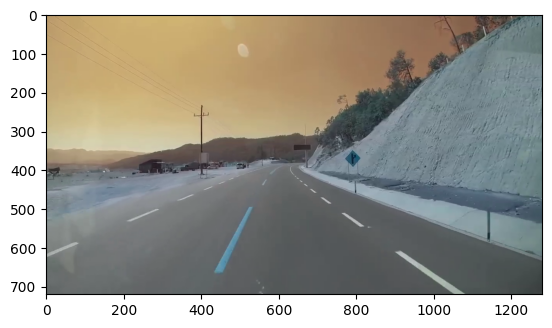

In [33]:
# Abrimos el video original como prueba
test_video = cv2.VideoCapture(original_video_path)

"""
Iteramos sobre la lectura del video, para obtener el fotograma en la posición 450, a razón de que el video 
está a 30 fotogramas por segundo, tomamos el primer fotograma del segundo 15. Se busca este instante de tiempo,
porque a esta altura del video el conductor prende las altas de su vehículo, permitiendo una mejor visibilidad del entorno.
"""
for _ in range(10):
    _, test_frame = test_video.read()

# Mostramos el fotograma
plt.imshow(test_frame)

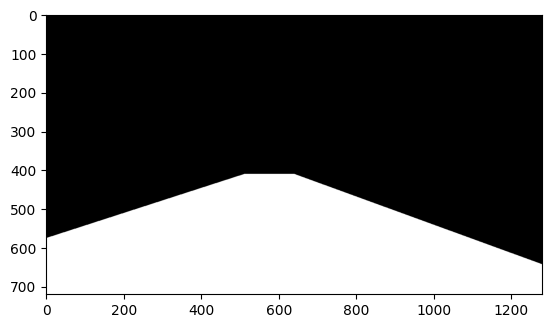

In [65]:
"""
Extraemos el conjunto completo de la imagen con líneas, los bordes de la imagen, 
y la imagen original en la región de interés, y la máscara usada
"""
lines_image, borders_image, mask_image, mask, lines_amount = extract_and_merge_lines(test_frame)

#Mostramos la máscara utilizada, la región blanca muestra la región que nos interesa, descartando la región negra.
plt.imshow(mask)

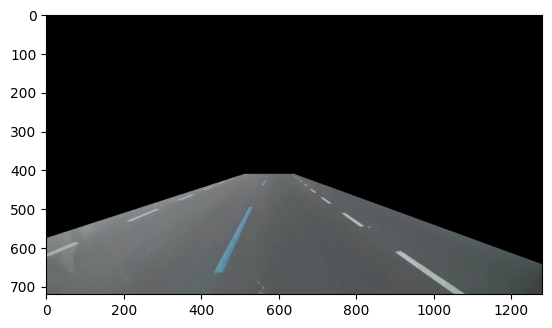

In [66]:
"""
Mostramos la imagen con la máscara aplicada, debido a que el video es de noche, no se aprecia tanta diferencia.
Sin embargo, eliminamos elementos como luces al fondo y algunas sombras al lado de la carretera.
Igualmente, en el video se aprecian en ocasiones vehículos que vienen en el otro sentido, por lo que igual se descartan.
"""
plt.imshow(mask_image)

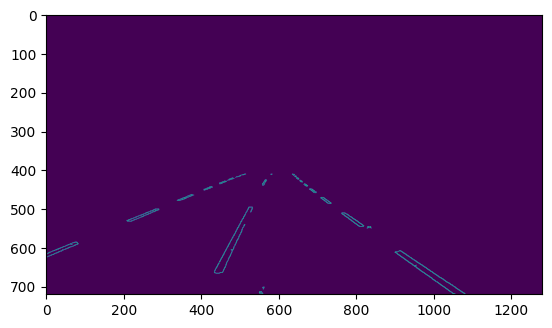

In [67]:
"""
Mostramos la imagen de los bordes obtenida a través de Canny, podemos notar que en este momento se notan las
líneas de los extremos de la carretera, así como las líneas discontinuas que separan ambos carriles.
"""
plt.imshow(borders_image)

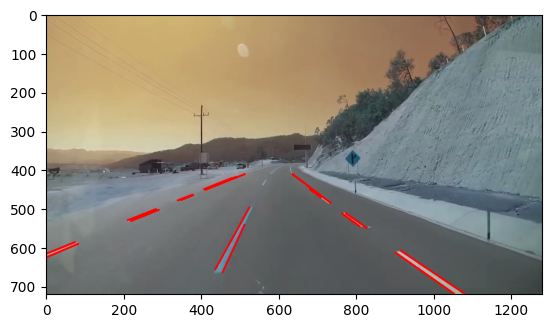

In [68]:
# Imprimimos la imagen con las líneas sobrepuestas
plt.imshow(lines_image)

In [69]:
"""
Imprimimos la cantidad de líneas luego de la transformada de Hough. Por lo que nos muestra la imágen, esperaríamos unos valores
óptimos entre 6 (solo los bordes laterales de cada límite de la carretera) y 10 (4 del límite separador de carriles y 
3 de las líneas límite de la carretera; 2 laterales y el extremo superior que pudiera detectarse).
Nosotros obtenemos un valor de 16, por lo que, al menos 1 línea está siendo segmentada en varias.
"""

print(lines_amount)

18


In [70]:
# Una vez realizada la explicación, liberamos el video para poder utilizarlo posteriormente.
test_video.release()

### Aquí finaliza la sección de explicación

-------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Visualización del funcionamiento del código: <a class="anchor" id="funcionamiento" ></a>
- La celda siguiente, al ser ejecutada, abre 2 ventanas, la primera con el video original y la segunda con el video modificado.
- Al modificar el tamaño de la ventana del video original, la otra ventana igualará este tamaño. Asímismo, al mover la ventana del video original, la segunda ventana mantendrá la misma distancia relativa a esta.

In [71]:
# Creamos el objeto del video original, leyendo la dirección establecida
original_video = cv2.VideoCapture(original_video_path)

# Creamos una ventana llamada "Original Video"
cv2.namedWindow('Original Video', cv2.WINDOW_NORMAL)

# Extablecemos unas medidas iniciales para esta ventana
cv2.resizeWindow('Original Video', 480, 270)

"""
Extraemos las medidas (ancho y alto), en pixeles, de los fotogramas que contiene el video de interés y 
creamos un "tuple" con esta información
"""
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4)) 
size = (frame_width, frame_height)

# Extraemos los fotogramas por segundo que contiene el video original
fps = int(original_video.get(5))

# Creamos el objeto del video modificado, con la ruta establecida, los "fps" y tamaño extraido del original
lines_video = cv2.VideoWriter(lines_video_path, cv2.VideoWriter_fourcc(*'MJPG'), fps, size)

# Extraemos las medidas y posición inicial de la ventana del video original
o_x0, o_y0, o_w, o_h = cv2.getWindowImageRect('Original Video')

# Creamos la ventana del video modificado, nombrada "Lines Video"
cv2.namedWindow('Lines Video', cv2.WINDOW_NORMAL)

# Asignamos las mismas medidas a la ventana del video modificado, que la del video original
cv2.resizeWindow('Lines Video', o_w, o_h)

#Movemos la ventana del video modificado para que se encuentre justo al lado de la original
cv2.moveWindow('Lines Video', o_x0+o_w+5, o_h-25)

# Mientras tengamos el video abierto, correr las instrucciones de dentro del ciclo
while(original_video.isOpened()):
    """
    Extraemos el fotograma siguiente "frame", y el booleano "success" representa la posibilidad deextraer 
    correctamente la información del frame
    """
    success, frame = original_video.read()
    
    # Si success es verdadero, entrar al if
    if success:
        
        # En la ventana del video original, mostrar el fotograma actual
        cv2.imshow('Original Video', frame)
        
        # Registrar si se presiona la tecla "q" en algún momento
        quitButton = cv2.waitKey(25) & 0xFF == ord('q')
        
        # Registrar si se hace click en el botón de cierre de la ventana original
        closeButton = cv2.getWindowProperty('Original Video', cv2.WND_PROP_VISIBLE) < 1
        
        # Extraemos las medidas y posición inicial de la ventana del video original
        o_x0, o_y0, o_w, o_h = cv2.getWindowImageRect('Original Video')
        
        # Extraemos la imagen del fotograma original con las líneas agregadas mediante la función "extract_and_merge_lines" 
        lines_image, _, _, _, _ = extract_and_merge_lines(frame)
        
        # Agregamos el fotograma de la imagen original con las líneas agregadas al video modificado
        lines_video.write(lines_image)
        
        # Mostramos la imagen con las líneas agregadas en la ventana del video modificado
        cv2.imshow('Lines Video', lines_image)
        
        #Movemos la ventana del video modificado para que se encuentre justo al lado de la original
        cv2.moveWindow('Lines Video', o_x0+o_w+5, o_y0-25)
        
        # Asignamos las mismas medidas a la ventana del video modificado, que la del video original
        cv2.resizeWindow('Lines Video', o_w, o_h)
        
        """
        Si se presionó la tecla "q" o se hizo click en el botón de cerrar de la ventana original, 
        entrar al if y destruir todas las ventanas existentes, además de terminar el ciclo while
        """
        if quitButton or closeButton:
            cv2.destroyAllWindows()
            
            break
    # En caso de que success sea falso, destruir todas las ventanas además de terminar el ciclo while
    else:
        cv2.destroyAllWindows()
        break

# Liberar los archivos de video original (lectura) y de video modificado (escritura), para poder utilizarlos normalmente
original_video.release()
lines_video.release()

### Conclusiones <a class="anchor" id="conclusion" ></a>

Una característica peculiar del video utilizado, es que se desempeña de noche, con poca luz exterior, además de los faros del propio auto, agregando también que, al tratarse de una carretera, se considera que el vehículo se movía a una velocidad de entre 100 y 120 km/h. En el video podemos apreciar 2 segmentos principales: 

1. Los primeros 12 segundos que están encendidas solo las luces normales
2. Los últimos 16, donde ya se cuenta con las luces "altas" permitiendo una mejor visibilidad y distinción de elementos (límites de la carretera). 

Observando el video final, y con las consideraciones ya descritas, de luminosidad y visibilidad, consideramos que este modelo tuvo un buen desempeño al momento de detectar los elementos principales.